In [105]:
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle

print(f'sklearn version {sklearn.__version__}')
print(f'pandas version {pd.__version__}')

from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_validate


sklearn version 1.3.0
pandas version 1.5.3


In [2]:
# Taxi trip data: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

def read_df(url="https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet"):
    df = pd.read_parquet(url)
    return df

df = read_df()
print(df.shape)
display(df.head())

(2964624, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [5]:
# df_back_up = df.copy()

In [21]:
df = df_back_up.copy()
def process_df(df:pd.DataFrame) -> pd.DataFrame:
    cols_to_remove = ['store_and_fwd_flag', 'payment_type', 'tip_amount', 'total_amount', 'PULocationID', 'DOLocationID']
    df = df.drop(cols_to_remove, axis=1)

    df['passenger_count'] = df['passenger_count'].astype('Int16')

    RatecodeIDMap = {
        1: "Standard rate",
        2: "JFK",
        3: "Newark",
        4: "Nassau or Westchester",
        5: "Negotiated fare",
        6: "Group ride",
    }
    df['RatecodeID'] = df['RatecodeID'].map(RatecodeIDMap).astype('category')
    df['VendorID'] = df['VendorID'].astype('category')
    
    diff = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime'])
    diff_mins = diff.dt.total_seconds()/60
    df['trip_duration_mins'] = round(diff_mins,2)
    df = df.drop(['tpep_dropoff_datetime', 'tpep_pickup_datetime'], axis=1)
    return df
    
df = process_df(df)
print(df.dtypes)
display(df.head())

VendorID                 category
passenger_count             Int16
trip_distance             float64
RatecodeID               category
fare_amount               float64
extra                     float64
mta_tax                   float64
tolls_amount              float64
improvement_surcharge     float64
congestion_surcharge      float64
Airport_fee               float64
trip_duration_mins        float64
dtype: object


,VendorID,passenger_count,trip_distance,RatecodeID,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,trip_duration_mins
0,2,1,1.72,Standard rate,17.7,1.0,0.5,0.0,1.0,2.5,0.0,19.80
1,1,1,1.80,Standard rate,10.0,3.5,0.5,0.0,1.0,2.5,0.0,6.60
2,1,1,4.70,Standard rate,23.3,3.5,0.5,0.0,1.0,2.5,0.0,17.92
3,1,1,1.40,Standard rate,10.0,3.5,0.5,0.0,1.0,2.5,0.0,8.30
4,1,1,0.80,Standard rate,7.9,3.5,0.5,0.0,1.0,2.5,0.0,6.10


In [12]:
df.describe()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,trip_duration_mins
count,2824462.0,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.824462e+06,2.824462e+06,2.964624e+06
mean,1.339281,3.652169e+00,1.817506e+01,1.451598e+00,4.833823e-01,5.270212e-01,9.756319e-01,2.256122e+00,1.411611e-01,1.561295e+01
std,0.850282,2.254626e+02,1.894955e+01,1.804102e+00,1.177600e-01,2.128310e+00,2.183645e-01,8.232747e-01,4.876239e-01,3.485105e+01
min,0.0,0.000000e+00,-8.990000e+02,-7.500000e+00,-5.000000e-01,-8.000000e+01,-1.000000e+00,-2.500000e+00,-1.750000e+00,-1.357000e+01
25%,1.0,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,0.000000e+00,1.000000e+00,2.500000e+00,0.000000e+00,7.150000e+00
50%,1.0,1.680000e+00,1.280000e+01,1.000000e+00,5.000000e-01,0.000000e+00,1.000000e+00,2.500000e+00,0.000000e+00,1.163000e+01
75%,1.0,3.110000e+00,2.050000e+01,2.500000e+00,5.000000e-01,0.000000e+00,1.000000e+00,2.500000e+00,0.000000e+00,1.868000e+01
max,9.0,3.127223e+05,5.000000e+03,1.425000e+01,4.000000e+00,1.159200e+02,1.000000e+00,2.500000e+00,1.750000e+00,9.455400e+03


In [13]:
df.corr(numeric_only=True)

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,trip_duration_mins
passenger_count,1.000000,0.011788,0.036255,-0.050986,-0.010787,0.029482,0.000597,0.008886,0.018451,0.021718
trip_distance,0.011788,1.000000,0.016065,0.001762,-0.000686,0.012163,-0.000162,-0.093102,0.237170,0.005398
fare_amount,0.036255,0.016065,1.000000,0.152778,0.074664,0.585995,0.218731,-0.136358,0.571233,0.247386
extra,-0.050986,0.001762,0.152778,1.000000,0.150880,0.240436,0.147055,0.076807,0.337079,0.033929
mta_tax,-0.010787,-0.000686,0.074664,0.150880,1.000000,-0.074372,0.906549,0.616339,0.069467,0.004230
tolls_amount,0.029482,0.012163,0.585995,0.240436,-0.074372,1.000000,0.053076,-0.101924,0.474774,0.152295
improvement_surcharge,0.000597,-0.000162,0.218731,0.147055,0.906549,0.053076,1.000000,0.588360,0.088731,0.010855
congestion_surcharge,0.008886,-0.093102,-0.136358,0.076807,0.616339,-0.101924,0.588360,1.000000,-0.295043,-0.056905
Airport_fee,0.018451,0.237170,0.571233,0.337079,0.069467,0.474774,0.088731,-0.295043,1.000000,0.145450
trip_duration_mins,0.021718,0.005398,0.247386,0.033929,0.004230,0.152295,0.010855,-0.056905,0.145450,1.000000


In [37]:
df = pd.get_dummies(df, drop_first=True)
df = df.dropna() # no patience....

X = df.drop('trip_duration_mins', axis=1)
y = df['trip_duration_mins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [46]:
lasso = linear_model.Lasso()
cv_results = cross_validate(lasso, X, y, cv=3, return_estimator=True)
print(cv_results['test_score'])

[0.06293984 0.05346654 0.0607179 ]


In [54]:
print(cv_results['estimator'][0].coef_)
model = cv_results['estimator'][0]

[ 0.          0.07849285  0.43224629 -0.         -0.          0.
 -0.         -0.          0.         -0.          0.          0.
 -0.         -0.         -0.         -0.        ]


In [55]:
y_train_predicted = model.predict(X_train)

(0.0, 60.0)

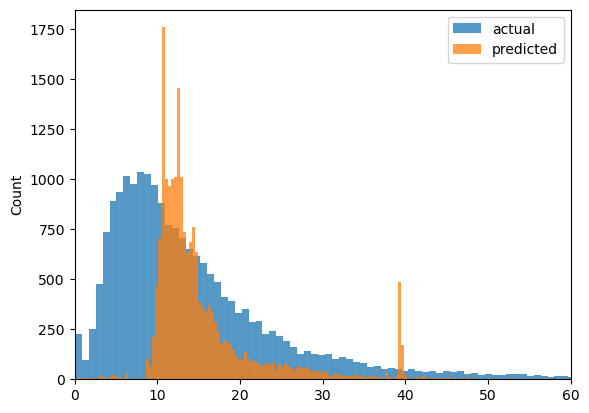

In [95]:
temp = np.random.choice(range(len(y_train)), 20000, False)

sns.histplot(np.array(y_train)[temp], label='actual')
sns.histplot(y_train_predicted[temp], label='predicted')
plt.legend()
plt.xlim([0, 60])

In [104]:
np.sqrt(np.sum((y_train - y_train_predicted)**2)/len(y_train))

34.940018652082045

In [107]:
!pwd

/Users/caiomiyashiro/repo/Personal/MLOpsZoomcamp/01-intro


In [108]:
with open('models/lasso_1_week.bin', 'wb') as f_out:
    pickle.dump(model, f_out)